# Stock Price Prediction

Let's say we want to make money by buying stocks. Since we want to make money, we only want to buy stock on days when the price will go up (we're against shorting the stock). We'll create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we won't do anything.

We want to maximize our true positives - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is true positives / (false positives + true positives). This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay, since we'd rather minimize our potential losses than maximize our potential gains.

### Method
Before we get to the machine learning, we need to do a lot of work to acquire and clean up the data. Here are the steps we'll follow:

- Download historical stock prices from Yahoo finance
- Explore the data
- Setup the dataset to predict future prices using historical prices
- Test a machine learning model
- Setup a backtesting engine
- Improve the accuracy of the model

We'll use data for a single stock (Microsoft) from when it started trading to the present.

In [1]:
import yfinance as yf
import os
import json
import pandas as pd

In [2]:
DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [3]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060274,0.063504,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062427,0.064042,0.062427,0.063504,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063504,0.064042,0.061350,0.061889,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061888,0.062427,0.060274,0.060812,47894400,0.0,0.0


<AxesSubplot:xlabel='Date'>

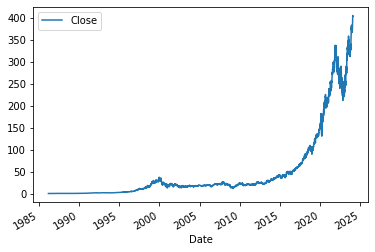

In [4]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [5]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [6]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [7]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [8]:
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062427,1.0,0.060274,1.031789e+09,0.054893,0.062965,0.054893
1986-03-17 00:00:00-05:00,0.063504,1.0,0.062427,3.081600e+08,0.060274,0.063504,0.060274
1986-03-18 00:00:00-05:00,0.061889,0.0,0.063504,1.331712e+08,0.062427,0.064042,0.062427
1986-03-19 00:00:00-05:00,0.060812,0.0,0.061889,6.776640e+07,0.063504,0.064042,0.061350
1986-03-20 00:00:00-05:00,0.059198,0.0,0.060812,4.789440e+07,0.061888,0.062427,0.060274


In [9]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

/home/heriG/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RandomForestClassifier(min_samples_split=200, random_state=1)

In [10]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6521739130434783

<AxesSubplot:xlabel='Date'>

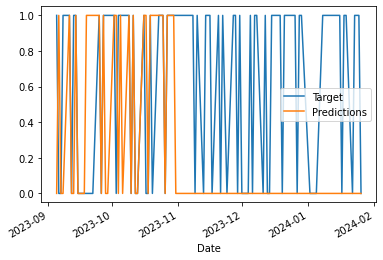

In [11]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [12]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [13]:
predictions = backtest(data, model, predictors)
predictions["Predictions"].value_counts()

0.0    7786
1.0     758
Name: Predictions, dtype: int64

In [14]:
precision_score(predictions["Target"], predictions["Predictions"])

0.503957783641161

## Improving accuracy

The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

In [15]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [16]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]